In [1]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import csv
import matplotlib.pyplot as plt

%matplotlib inline

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [31]:
conn = sql.connect("..\db.sqlite3")
cur = conn.cursor()

query = """
SELECT
    restaurant_order.id as order_id,
    restaurant_order.datetime as order_time,
    restaurant_product.name as product_name,
    restaurant_product.price as product_price,
    restaurant_orderitem.quantity as product_quantity
FROM restaurant_order
INNER JOIN main.restaurant_orderitem
ON restaurant_order.id = restaurant_orderitem.order_id
INNER JOIN main.restaurant_product
ON restaurant_product.id = restaurant_orderitem.product_id;
"""

cur.execute(query)

with open("restaurant_data.csv", "w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow([i[0] for i in cur.description])
    csv_writer.writerows(cur)

In [2]:
df = pd.read_csv("restaurant_data.csv")
df

,order_id,order_time,product_name,product_price,product_quantity
0,1,2019-08-03 20:25:00,Plain Papadum,0.80,2
1,1,2019-08-03 20:25:00,King Prawn Balti,12.95,1
2,1,2019-08-03 20:25:00,Garlic Naan,2.95,1
3,1,2019-08-03 20:25:00,Mushroom Rice,3.95,1
4,1,2019-08-03 20:25:00,Paneer Tikka Masala,8.95,1
...,...,...,...,...,...
74813,3255,2016-05-18 18:53:00,House Red wine 75cl,17.95,2
74814,12905,2016-05-14 19:28:00,House Red wine 75cl,17.95,2
74815,3272,2016-05-10 13:18:00,House Red wine 75cl,17.95,2
74816,11404,2016-04-07 19:04:00,House white wine 75cl,17.95,1


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

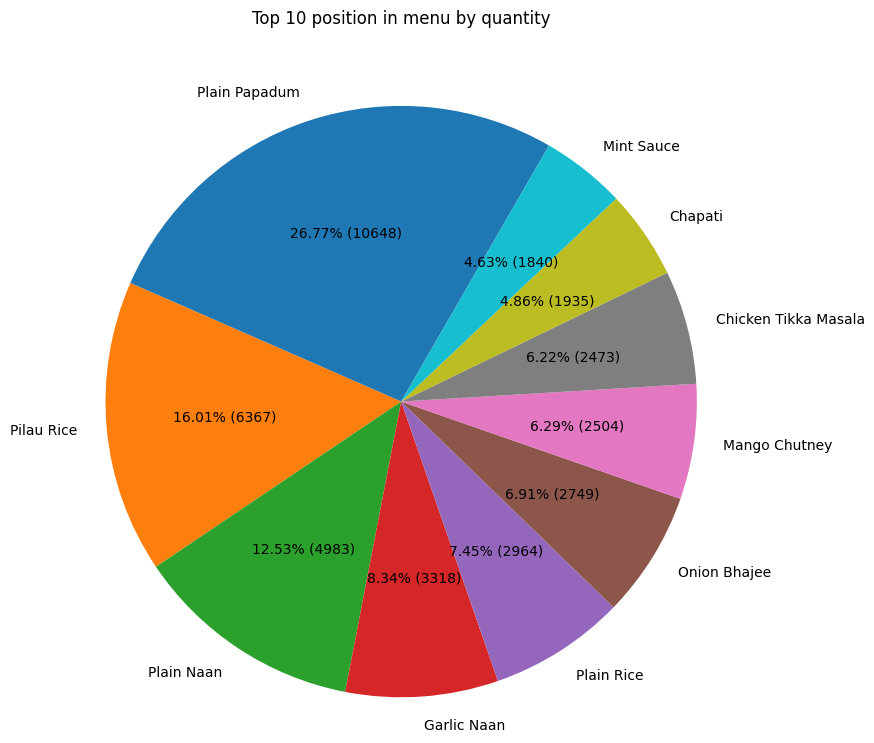

In [3]:
product_group = (
    df.groupby(
        by=["product_name", "product_price"],
        as_index=False
    )
    .sum()
    .sort_values(
        by="product_quantity", ascending=False
    )
)

popular_products = product_group.iloc[:10]

plt.title("Top 10 position in menu by quantity", y=1.5)

plt.pie(
    x=popular_products.product_quantity,
    labels=popular_products.product_name,
    autopct=lambda p: f"{p:.2f}% ({p * popular_products.product_quantity.sum() / 100:.0f})",
    startangle=60,
    radius=2
)

plt.show()

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

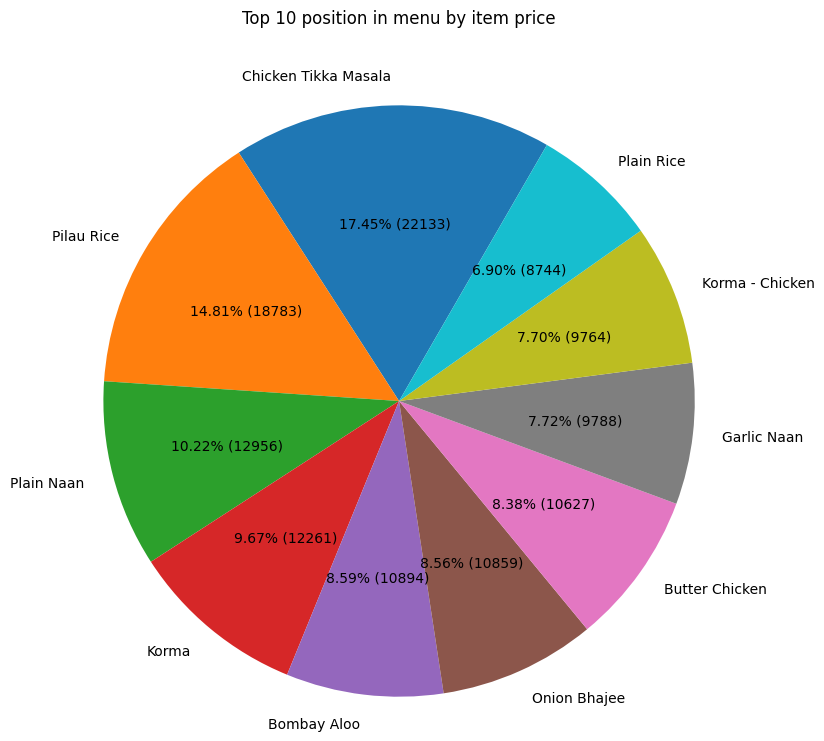

In [4]:
product_group["item_price"] = product_group["product_price"] * product_group["product_quantity"]
top_price_products = product_group.sort_values(by="item_price", ascending=False).iloc[:10]

plt.title("Top 10 position in menu by item price", y=1.5)

plt.pie(
    x=top_price_products.item_price,
    labels=top_price_products.product_name,
    autopct=lambda p: f"{p:.2f}% ({p * top_price_products.item_price.sum() / 100:.0f})",
    startangle=60,
    radius=2
)

plt.show()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

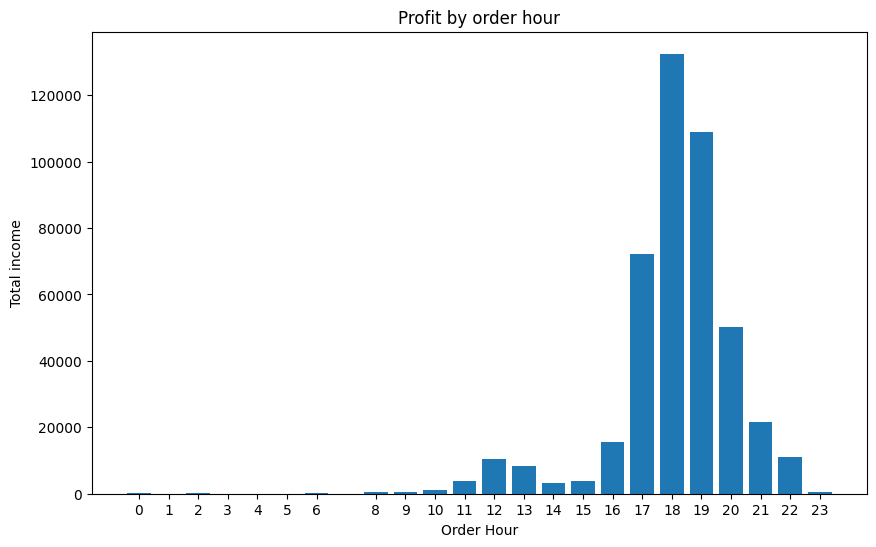

In [10]:
df["order_time"] = pd.to_datetime(df["order_time"], format="%Y-%m-%d %H:%M:%S")
df["order_hour"] = df["order_time"].dt.hour
df["product_full_price"] = df["product_quantity"] * df["product_price"]

order_group = df.groupby(by="order_hour", as_index=False)
total_income_group = order_group.product_full_price.sum()

total_income = total_income_group.product_full_price
order_hour = total_income_group.order_hour

plt.figure(figsize=(10, 6))
plt.title("Profit by order hour")
plt.xlabel("Order Hour")
plt.ylabel("Total income")
plt.xticks(order_hour)

plt.bar(x=order_hour, height=total_income, label="Bar plot")
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

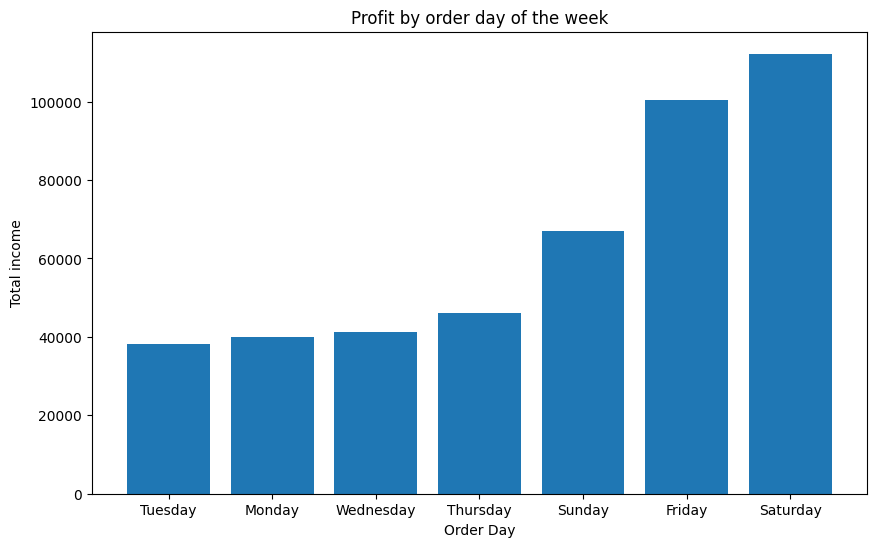

In [20]:
df["order_day_of_the_week"] = df["order_time"].dt.day_name()

order_day_group = df.groupby(
    by="order_day_of_the_week",
    as_index=False
)
total_income_group = (
    order_day_group.product_full_price
    .sum()
    .sort_values(
        by="product_full_price"
    )
)

total_income = total_income_group.product_full_price
order_day = total_income_group.order_day_of_the_week

plt.figure(figsize=(10, 6))
plt.title("Profit by order day of the week")
plt.xlabel("Order Day")
plt.ylabel("Total income")

plt.bar(x=order_day, height=total_income, label="Bar plot")
plt.show()